In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,f1_score,confusion_matrix,roc_auc_score,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBRegressor,XGBClassifier

In [2]:
data=pd.read_csv('C:/Users/zhouwei/Desktop/SupplyChain/SupplyChain.csv',encoding='unicode_escape')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [3]:
data.isnull().sum()[data.isnull().sum()>0]

Customer Lname              8
Customer Zipcode            3
Order Zipcode          155679
Product Description    180519
dtype: int64

In [4]:
#将姓名进行合并
data['fullname']=data['Customer Fname']+data['Customer Lname']


In [5]:
data['Customer Zipcode'].value_counts()

725.0      66770
921.0        337
23455.0      334
957.0        297
79109.0      292
           ...  
60636.0       18
89015.0       16
32210.0       15
7728.0        13
11225.0        9
Name: Customer Zipcode, Length: 995, dtype: int64

In [6]:
data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)

<AxesSubplot:>

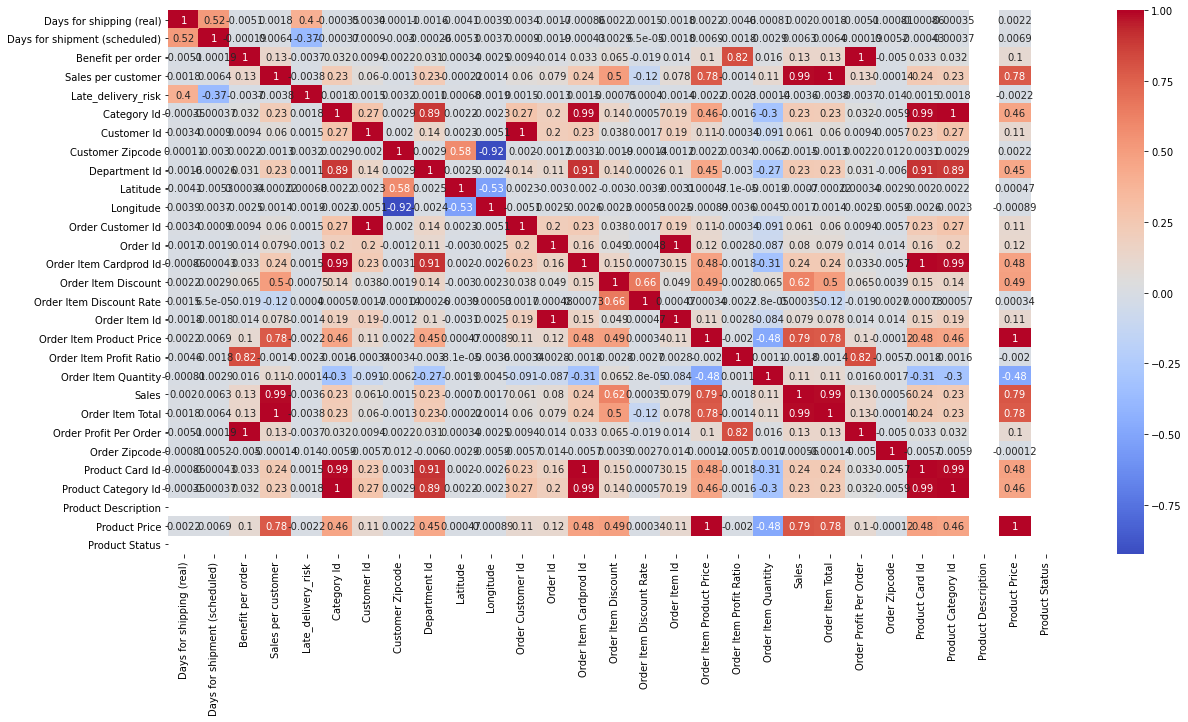

In [7]:
#数据的相关性
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

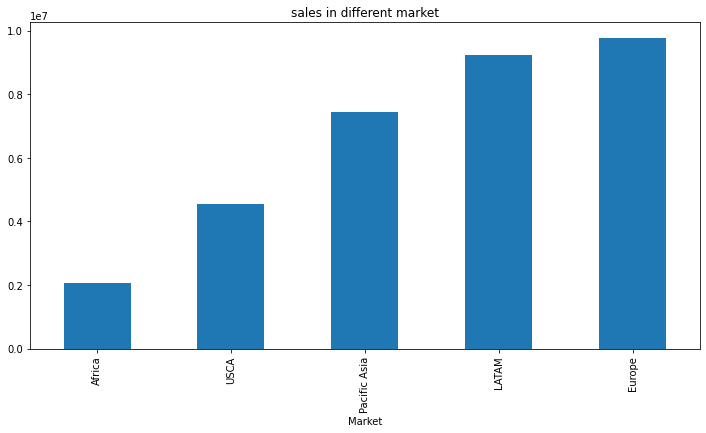

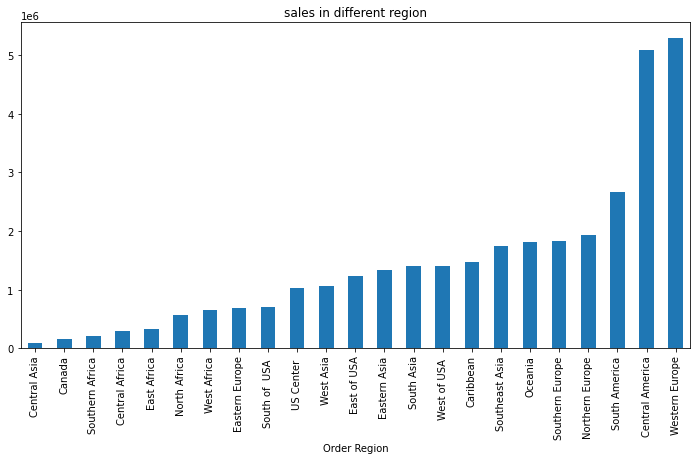

In [8]:
#基于market进行聚合
market=data.groupby('Market')
#基于region 进行聚合
region=data.groupby('Order Region')
market['Sales per customer'].sum().sort_values(ascending=True).plot.bar(figsize=(12,6),title='sales in different market')
plt.show()
region['Sales per customer'].sum().sort_values(ascending=True).plot.bar(figsize=(12,6),title='sales in different region')
plt.show()


<AxesSubplot:title={'center':'sales in different category'}, xlabel='Category Name'>

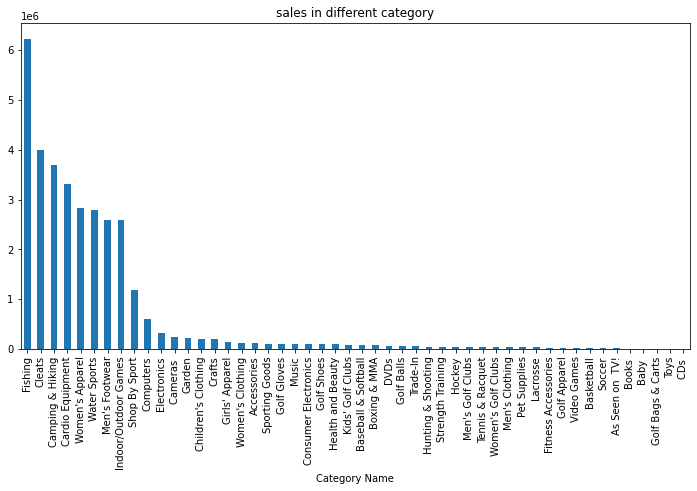

In [9]:
#基于不同category进行聚类
cat=data.groupby('Category Name')
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6),title='sales in different category')


Text(7.1, 0.8486774898937535, '累计占比为:84.87%')

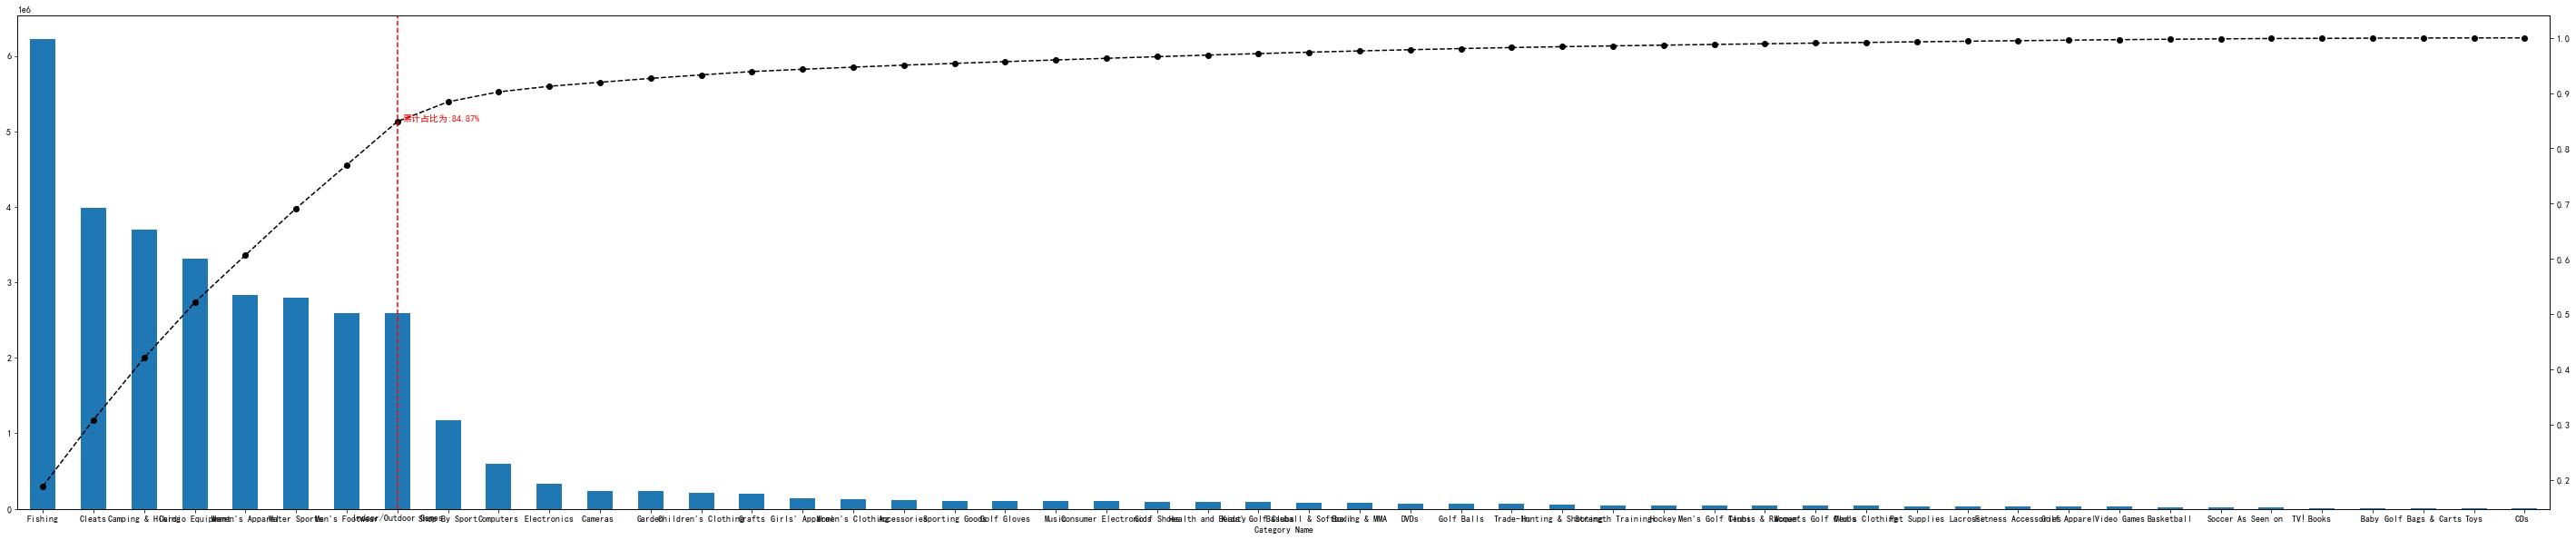

In [10]:
#对不同category进行帕累托分析
sales_cat=cat['Sales per customer'].sum().sort_values(ascending=False)
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(50,10))
sales_cat.plot.bar()
#累计概率
p=sales_cat.cumsum()/sales_cat.sum()
#找到累计概率大于0.8的index
key=p[p>0.8].index[0]
key_sum=sales_cat.index.tolist().index(key)
p.plot(style='--ko',secondary_y=True)
plt.axvline(key_sum,color='r',linestyle='--')
plt.text(key_sum+0.1,p[key],'累计占比为:%.2f%%'%(p[key]*100),color='red')

In [11]:
#按照不同的时间维度进行聚类
temp=pd.DatetimeIndex(data['order date (DateOrders)'])
data['order_year']=temp.year
data['order_month']=temp.month
data['order_week_day']=temp.weekday
data['order_hour']=temp.hour
data['order_month_year']=temp.to_period('M')


<AxesSubplot:title={'center':'Average sales in month'}, xlabel='order_month'>

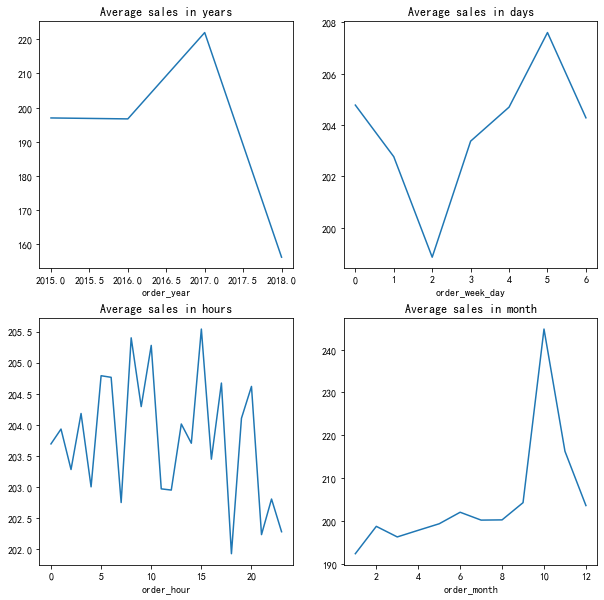

In [12]:
#按照年月星期小时对销售额进行探索
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
df_year=data.groupby('order_year')
df_year['Sales'].mean().plot(title='Average sales in years')
plt.subplot(2,2,2)
df_day=data.groupby('order_week_day')
df_day['Sales'].mean().plot(title='Average sales in days')
plt.subplot(2,2,3)
df_hour=data.groupby('order_hour')
df_hour['Sales'].mean().plot(title='Average sales in hours')
plt.subplot(2,2,4)
df_month=data.groupby('order_month')
df_month['Sales'].mean().plot(title='Average sales in month')

Text(0, 0.5, 'sales per customer')

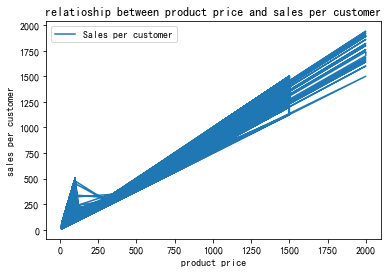

In [13]:
#product price与sale per customer 相关性如何
data.plot(x='Product Price',y='Sales per customer')
plt.title('relatioship between product price and sales per customer')
plt.xlabel('product price')
plt.ylabel('sales per customer')

<AxesSubplot:>

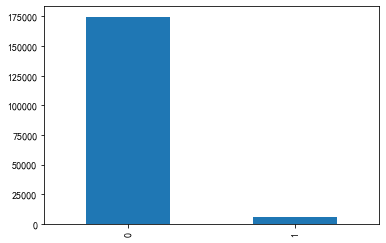

In [14]:
#对城市以及国家分布进行分析
#将订单分为海内海外，得出海内外订单数量的分布
data['orderplace']=data['Order Country'].map(lambda x:int(x =='China'))
data['orderplace'].value_counts().plot.bar()

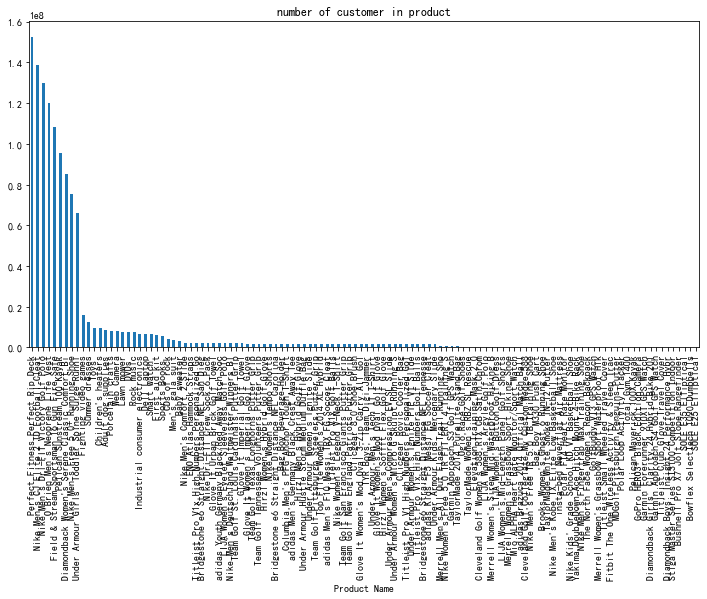

<AxesSubplot:title={'center':'numer of customer for category '}, xlabel='Category Name'>

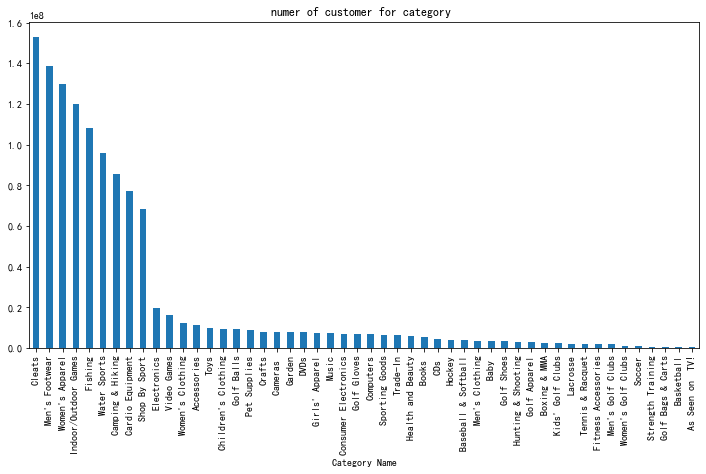

In [15]:
#对商品以及商品类别所购买的人数进行分析,得出哪类商品最受消费者欢迎
product=data.groupby('Product Name')
product['Customer Id'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6),title='number of customer in product')
plt.show()
product_cat=data.groupby('Category Name')
product_cat['Customer Id'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6),title='numer of customer for category ')

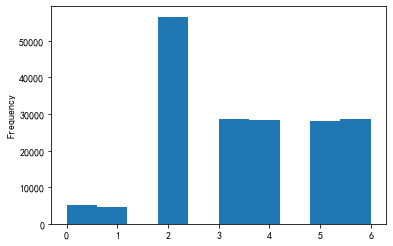

<AxesSubplot:>

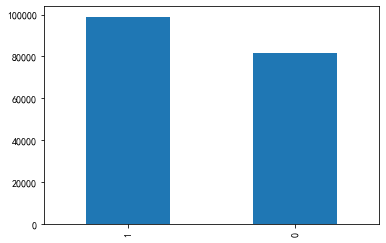

In [16]:
#分析订单发货时间，以及延迟订单
data['Days for shipping (real)'].plot.hist()
plt.show()
data['Late_delivery_risk'].value_counts().plot.bar()

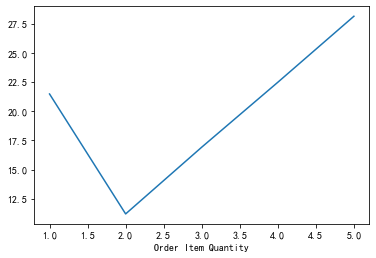

<AxesSubplot:xlabel='Order Item Quantity'>

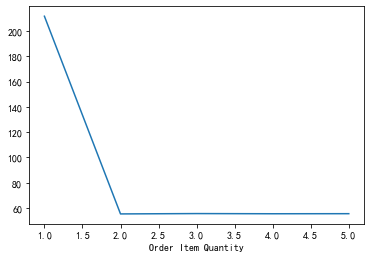

In [17]:
#订单购买数量与价格商品价格以及折扣之间关系
data.groupby('Order Item Quantity')['Order Item Discount'].mean().plot()
plt.show()
data.groupby('Order Item Quantity')['Order Item Product Price'].mean().plot()

In [24]:
#使用RFM进行分层，统计最后一笔时间
data['order date (DateOrders)']=pd.to_datetime(data['order date (DateOrders)'])
data['order date (DateOrders)'].max()

Timestamp('2018-01-31 23:38:00')

In [25]:
import datetime 
present=datetime.datetime(2018,2,1)
present

datetime.datetime(2018, 2, 1, 0, 0)

In [35]:
#order custeomer id 进行聚合
customer_set=data.groupby('Order Customer Id').agg({'order date (DateOrders)':lambda x:(present-x.max()).days,'Order Id':lambda x:len(x),'Sales':lambda x:x.sum()})
customer_set
#将字段进行改名
customer_set=customer_set.rename(columns={'order date (DateOrders)':'r_value','Order Id':'f_value','Sales':'m_value'})
customer_set

,r_value,f_value,m_value
Order Customer Id,,,
1,792,1,499.950012
2,136,10,1819.730034
3,229,18,3537.680094
4,380,14,1719.630030
5,457,7,1274.750023
...,...,...,...
20753,0,1,215.820007
20754,0,1,215.820007
20755,0,1,327.750000


In [36]:
quantiles=customer_set.quantile(q=[0.25,0.5,0.75])
quantiles=quantiles.to_dict()
quantiles

{'r_value': {0.25: 75.0, 0.5: 159.0, 0.75: 307.0},
 'f_value': {0.25: 1.0, 0.5: 7.0, 0.75: 15.0},
 'm_value': {0.25: 293.0400085, 0.5: 1499.82503324, 0.75: 2915.8800654175}}

In [37]:
#将值转化成【1-4】之间
def r_score(a,b,c):
    if a<=c[b][0.25]:
        return 4
    elif a<=c[b][0.5]:
        return 3
    elif a<=c[b][0.75]:
        return 2
    else:
        return 1
def fm_score(a,b,c):
    if a<=c[b][0.25]:
        return 1
    elif a<=c[b][0.5]:
        return 2
    elif a<=c[b][0.75]:
        return 3
    else:
        return 4


In [38]:
#新建recency score 字段,将rvalue转换成【1-4】之间
customer_set['r_score']=customer_set['r_value'].apply(r_score,args=('r_value',quantiles))
customer_set['f_score']=customer_set['f_value'].apply(fm_score,args=('f_value',quantiles))
customer_set['m_score']=customer_set['m_value'].apply(fm_score,args=('m_value',quantiles))

In [39]:
#计算RFM 用户分层
def rfm_user(df):
    if df['m_score']>2 and df['f_score']>2 and df['r_score']>2:
        return '重要价值用户'
    if df['m_score']>2 and df['f_score']<=2 and df['r_score']>2:
        return '重要发展客户'
    if df['m_score']>2 and df['f_score']>2 and df['r_score']<=2:
        return '重要保持客户'
    if df['m_score']>2 and df['f_score']<=2 and df['r_score']<=2:
        return '重要挽留客户'
    if df['m_score']<=2 and df['f_score']>2 and df['r_score']>2:
        return '一般价值用户'
    if df['m_score']<=2 and df['f_score']<=2 and df['r_score']>2:
        return '一般发展客户'
    if df['m_score']<=2 and df['f_score']>2 and df['r_score']<=2:
        return '一般保持客户'
    if df['m_score']<=2 and df['f_score']<=2 and df['r_score']<=2:
        return '一般挽留客户'

In [41]:
customer_set['customer_seg']=customer_set.apply(rfm_user,axis=1)  
customer_set

,r_value,f_value,m_value,r_score,f_score,m_score,customer_seg
Order Customer Id,,,,,,,
1,792,1,499.950012,1,1,2,一般挽留客户
2,136,10,1819.730034,3,3,3,重要价值用户
3,229,18,3537.680094,2,4,4,重要保持客户
4,380,14,1719.630030,1,3,3,重要保持客户
5,457,7,1274.750023,1,2,2,一般挽留客户
...,...,...,...,...,...,...,...
20753,0,1,215.820007,4,1,1,一般发展客户
20754,0,1,215.820007,4,1,1,一般发展客户
20755,0,1,327.750000,4,1,2,一般发展客户


In [42]:
#显示不同地区的支付类型
data['Type'].value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

In [43]:
pay_type1=data[data['Type']=='DEBIT']
pay_type2=data[data['Type']=='TRANSFER']
pay_type3=data[data['Type']=='PAYMENT']
pay_type4=data[data['Type']=='CASH']

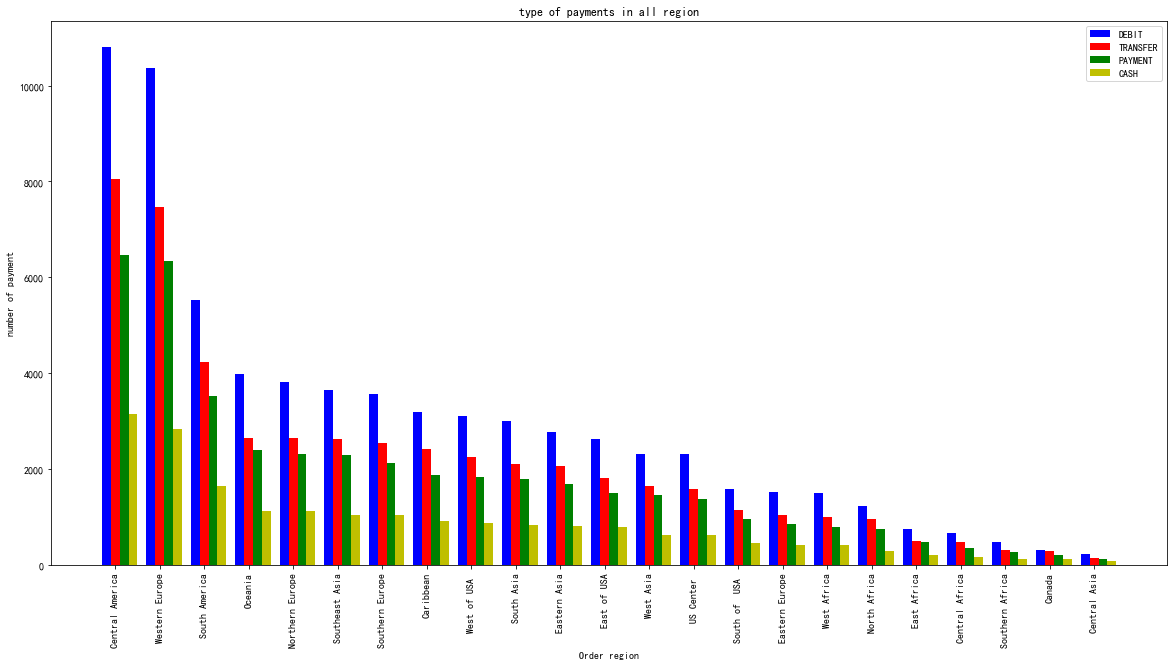

In [44]:
#不同地区支付类型的特征
count1=pay_type1['Order Region'].value_counts()
count2=pay_type2['Order Region'].value_counts()
count3=pay_type3['Order Region'].value_counts()
count4=pay_type4['Order Region'].value_counts()
#获取地区的地区的个数
region_num=len(count1)
fig,ax=plt.subplots(figsize=(20,10))
index =np.arange(region_num)
bar_width=0.2
type1=plt.bar(index,count1,bar_width,color='b',label='DEBIT')
type2=plt.bar(index+bar_width,count2,bar_width,color='r',label='TRANSFER')
type1=plt.bar(index+bar_width*2,count3,bar_width,color='g',label='PAYMENT')
type1=plt.bar(index+bar_width*3,count4,bar_width,color='y',label='CASH')
plt.legend()
plt.xlabel('Order region')
plt.ylabel('number of payment')
plt.title('type of payments in all region')
#显示刻度
names=data['Order Region'].value_counts().keys()
plt.xticks(index+bar_width,names,rotation='vertical')
plt.show()

<AxesSubplot:>

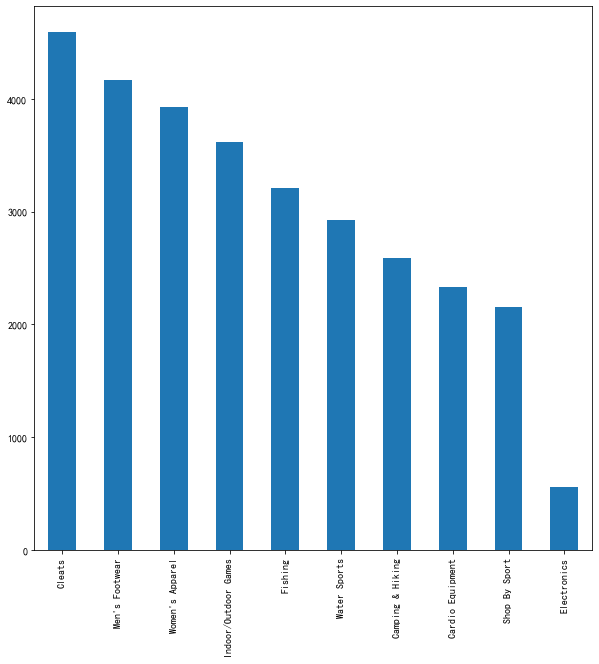

In [45]:
#对付收益产品进行探索
loss=data[data['Benefit per order']<0]
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(10,10))

<AxesSubplot:>

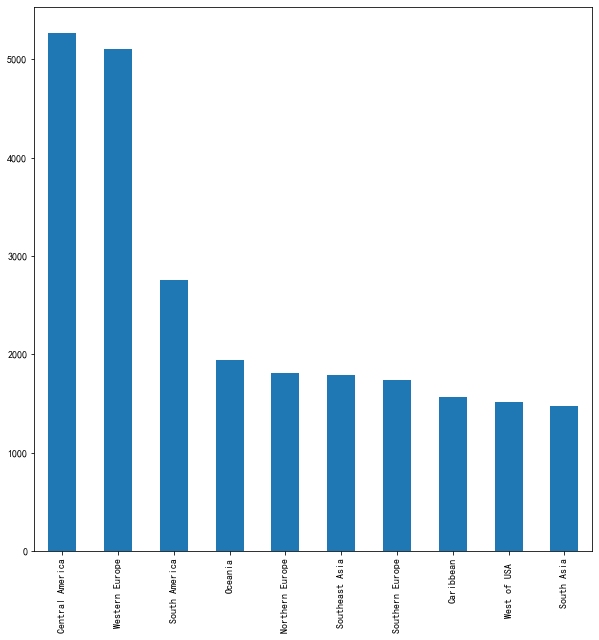

In [46]:
#显示负收益地区分布
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(10,10))

In [47]:
#所有负收益产品所带来的损失
print('总损失：',loss['Benefit per order'].sum())
data['Order Status'].value_counts()

总损失： -3883547.345768667


COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order Status, dtype: int64

In [48]:
data['Order Status'].value_counts()

COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order Status, dtype: int64

In [49]:
#f负收益产生的欺诈交易主要方式
data[data['Order Status']=='SUSPECTED_FRAUD']['Type'].value_counts()

TRANSFER    4062
Name: Type, dtype: int64

Text(0, 0.5, 'fraud number')

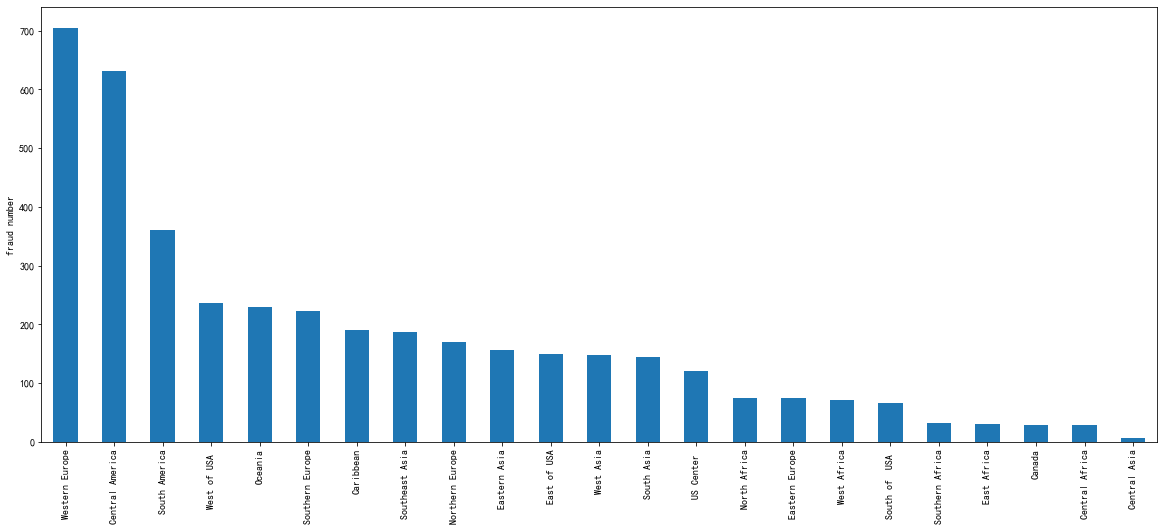

In [50]:
#显示不同地区的欺诈交易情况
high_fraud=data[data['Order Status']=='SUSPECTED_FRAUD']
high_fraud['Order Region'].value_counts().plot.bar(figsize=(20,8))
plt.ylabel('fraud number')


Text(0.5, 0, 'product')

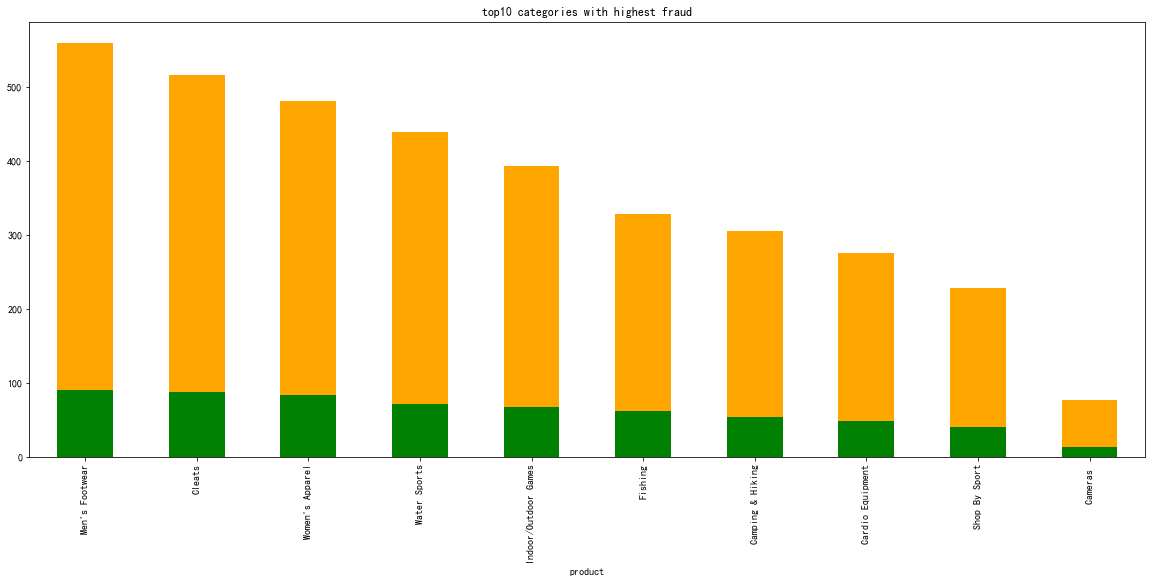

In [51]:
#western euroupe 地区欺诈交易最多，将一个bar 分成两个部分（堆积条形图）
high_fraud_total=data[data['Order Status']=='SUSPECTED_FRAUD']
high_fraud_west=data[(data['Order Status']=='SUSPECTED_FRAUD')&(data['Order Region']=='Western Europe')]
#找出风险最高的10个类型
fraud1=high_fraud_total['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8),title='Fraud category',color='orange')
fraud2=high_fraud_west['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8),title='Fraud category in western europe',color='green')
plt.title('top10 categories with highest fraud')
plt.xlabel('product')

<AxesSubplot:>

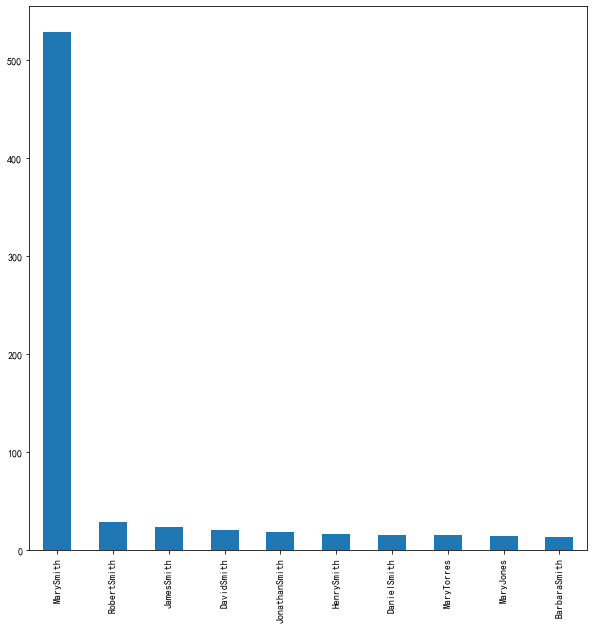

In [52]:
#筛选fraud的前十个customer
cus=data[data['Order Status']=='SUSPECTED_FRAUD']
cus['fullname'].value_counts().nlargest(10).plot.bar(figsize=(10,10))

In [53]:
#找到marysmith的交易金额以及违约金额
print(data[data['fullname']=='MarySmith']['Sales'].sum())
print(data[(data['fullname']=='MarySmith')&(data['Order Status']=='SUSPECTED_FRAUD')]['Sales'].sum())

4771645.883297398
102491.66191043999


# 对数据进行建模

In [54]:
data['fraud']=np.where(data['Order Status']=='SUSPECTED_FRAUD',1,0)
data['Delivery Status'].value_counts()
data['late_delivery']=np.where(data['Delivery Status']=='Late delivery',1,0)

In [55]:
data.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [56]:
#将不需要的特征进行删除
data=data.drop(['Customer Email','Customer Password','Product Status','Product Description','Product Image',\
                'Customer Lname','Customer Fname','Order Customer Id','Order Item Cardprod Id',\
               'Order Item Id','Sales per customer','Order Item Total','Order Profit Per Order','Product Card Id',\
               'Product Category Id','Product Price','Order Zipcode','shipping date (DateOrders)',\
               'Latitude','Longitude','Customer Street','order_month_year','order date (DateOrders)','Order Status','Delivery Status','Late_delivery_risk'],axis=1)

In [57]:
data['fullname'].isnull().sum()

8

In [58]:
data=data.dropna(subset=['fullname'])

In [59]:
#查看分类变量
cat_cols=data.select_dtypes(include='object').columns
cat_cols

#进行lableencoder 
label=LabelEncoder()
for cat in cat_cols:
    data[cat]=label.fit_transform(data[cat])


In [60]:
#对欺诈数据进行建模
x_fraud=data.loc[:,data.columns!='fraud']
y_fraud=data['fraud']
x_late=data.loc[:,data.columns!='late_delivery']
y_late=data['late_delivery']

In [61]:
#对数据集进行切分
x_fraud_train,x_fraud_test,y_fraud_train,y_fraud_test=train_test_split(x_fraud,y_fraud,test_size=0.2)
x_late_train,x_late_test,y_late_train,y_late_test=train_test_split(x_late,y_late,test_size=0.2)
#对数据进行规范化
sc=StandardScaler()
x_fraud_train=sc.fit_transform(x_fraud_train)
x_fraud_test=sc.fit_transform(x_fraud_test)
x_late_train=sc.fit_transform(x_late_train)
x_late_test=sc.fit_transform(x_late_test)

In [80]:
def model_stats(model,x_train,x_test,y_train,y_test,name='Fraud'):
    model=model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    accuracy=accuracy_score(y_pred,y_test)
    recall=recall_score(y_pred,y_test)
    roc_score=roc_auc_score(y_pred,y_test)
    confusion=confusion_matrix(y_pred,y_test)
    f1=f1_score(y_pred,y_test)
    print('model used:',model)
    print('{}accuracy:{}'.format(name,accuracy))
    print('{}recall:{}'.format(name,recall))
    print('{}roc_score:{}'.format(name,roc_score))
    print('{}confusion:{}'.format(name,confusion))
    print('{}f1_score:{}'.format(name,f1))
    

In [81]:
model_fraud=LogisticRegression()
model_logist=LogisticRegression()
model_stats(model_fraud,x_fraud_train,x_fraud_test,y_fraud_train,y_fraud_test,'Fraud')
model_stats(model_logist,x_late_train,x_late_test,y_late_train,y_late_test,'latedelivery')

D:\anocada\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


model used: LogisticRegression()
Fraudaccuracy:0.9783674486884747
Fraudrecall:0.5700934579439252
Fraudroc_score:0.7760617644646685
Fraudconfusion:[[35139   643]
 [  138   183]]
Fraudf1_score:0.3190932868352223
model used: LogisticRegression()
latedeliveryaccuracy:0.9881173309697255
latedeliveryrecall:0.9787170709927072
latedeliveryroc_score:0.9893585354963537
latedeliveryconfusion:[[15946     0]
 [  429 19728]]
latedeliveryf1_score:0.9892440767205716


In [85]:
#使用树模型得出特征重要性,并进行可视化
tree_model=RandomForestClassifier(n_estimators=500,max_depth=10,random_state=2020)
tree_model.fit(x_fraud_train,y_fraud_train)
y_fraud_predict=tree_model.predict(x_fraud_test)
print('accuracy_score:',accuracy_score(y_fraud_predict,y_fraud_test))


accuracy_score: 0.9771210148741102


Text(0.5, 1.0, 'fraud feature importance chart')

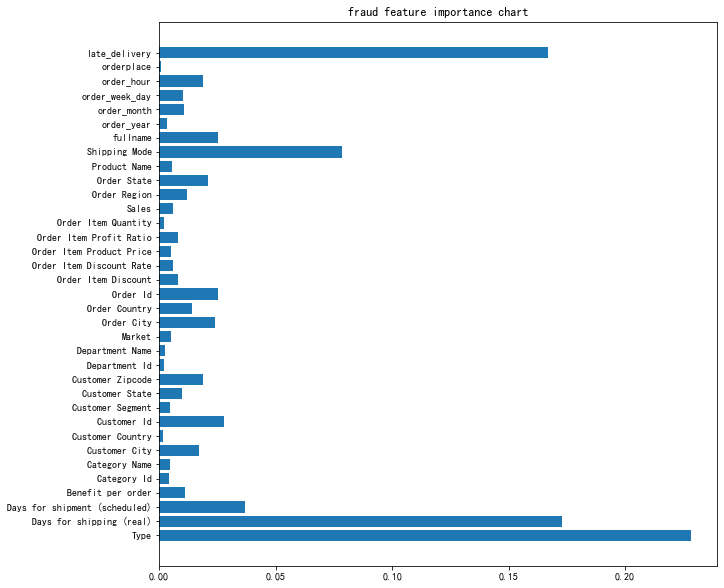

In [79]:
plt.figure(figsize=(10,10))
plt.barh(x_fraud.columns,tree_model.feature_importances_)
plt.title('fraud feature importance chart')

In [90]:
xgc=XGBClassifier(max_depth=10,learning_rate=0.1,min_child_weight=100,random_state=2020)
xgc.fit(x_late_train,y_late_train)
y_late_predict=xgc.predict(x_late_test)
print('accuracy_score:',accuracy_score(y_late_predict,y_late_test))

accuracy_score: 0.9881173309697255


Text(0.5, 1.0, 'late delivery feature importance chart')

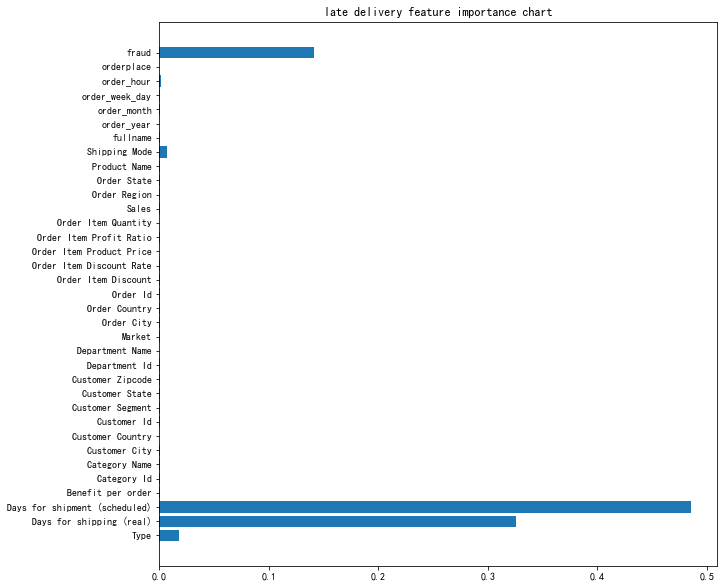

In [92]:
plt.figure(figsize=(10,10))
plt.barh(x_late.columns,xgc.feature_importances_)
plt.title('late delivery feature importance chart')

In [104]:
#对sales,定单数量进行建模
x_sales=data.loc[:,data.columns!='Sales']
y_sales=data['Sales']
x_quantity=data.loc[:,data.columns!='Order Item Quantity']
y_quantity=data['Order Item Quantity']

In [109]:
x_train_sales,x_test_sales,y_train_sales,y_test_sales=train_test_split(x_sales,y_sales,train_size=0.8,random_state=2020)
x_train_quantity,x_test_quantity,y_train_quantity,y_test_quantity=train_test_split(x_quantity,y_quantity,train_size=0.8,random_state=2020)
#对数据进行规范化
sc=StandardScaler()
x_train_sales=sc.fit_transform(x_train_sales)
x_test_sales=sc.fit_transform(x_test_sales)
x_train_quantity=sc.fit_transform(x_train_quantity)
x_test_quantity=sc.fit_transform(x_test_quantity)

In [110]:
#对sales,订单数量进行预估
def model_sale_and_quantity(data,x_train,y_train,x_test,y_test,name='sales'):
    model=XGBRegressor(n_estimators=1000,max_depth=10,learning_rate=0.1,random_state=2020)
    model.fit(x_train,y_train)
    y_predict=model.predict(x_test)
    print('{}mae：{}'.format(name,mean_absolute_error(y_predict,y_test)))
    print('{}r2：{}'.format(name,r2_score(y_predict,y_test)))
    plt.figure(figsize=(10,10))
    plt.barh(data.columns,model.feature_importances_)
    plt.title('{} feature_imporatance graph'.format(name))
    plt.show()

salesmae：0.14306896638109567
salesr2：0.9999505347527124


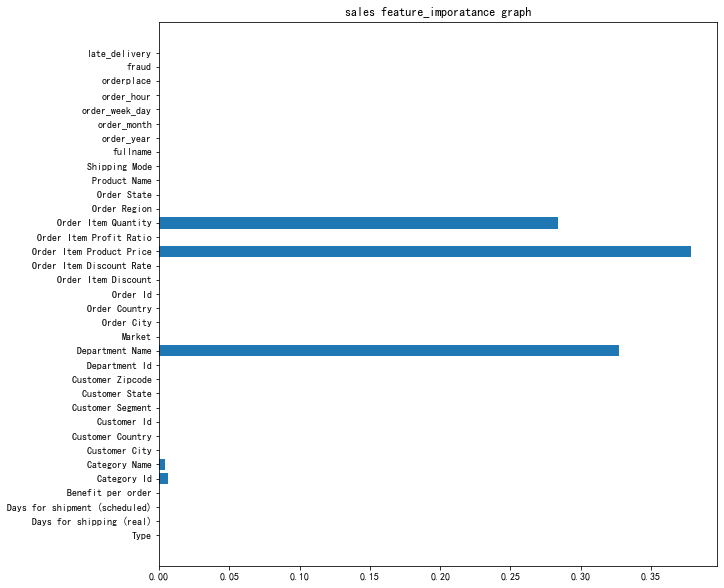

In [111]:
model_sale_and_quantity(x_sales,x_train_sales,y_train_sales,x_test_sales,y_test_sales,'sales')

quantitymae：0.0015548762266607433
quantityr2：0.9996207873228924


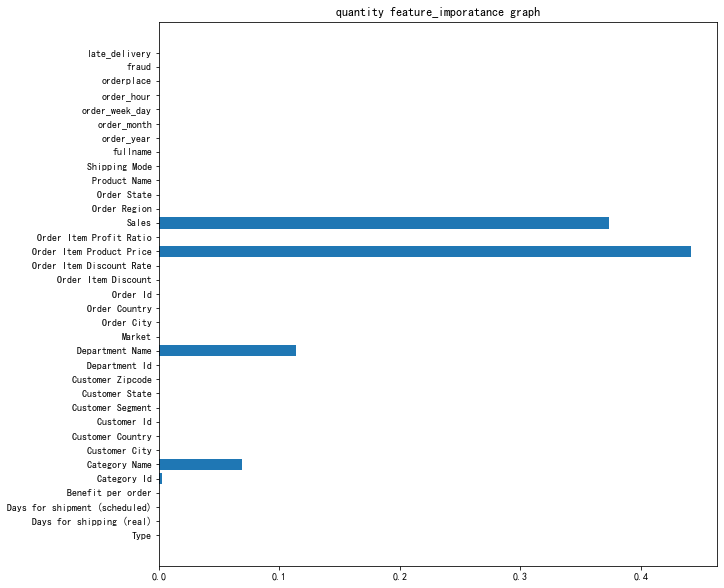

In [113]:
model_sale_and_quantity(x_quantity,x_train_quantity,y_train_quantity,x_test_quantity,y_test_quantity,'quantity')